# Random Forest Model on Titanic Data

The goal of this project is to use random forest to predict survivability on titanic dataset

## Dataset Features
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way

Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats as st

In [43]:
def hypothesis_statistics(s1, s2,  p1, p2, alpha):
  P1  = s1/p1
  P2 = s2/p2
  p = (s1 + s2)/(p1 +p2)
  Z = (P1 - P2)/math.sqrt(p * (1-p)* ((1/p1)+(1/p2)))
  alp = st.norm.ppf(1 - (alpha/2))

  if Z < alp:
    return f"{Z} Test does not fall in rejection region, Accept H0"
  else:
    return f"{Z} Test falls within rejection region, reject H0"

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/komus/business_analytics/master/tree_based_model/titanic3.csv")
train = pd.read_csv("https://raw.githubusercontent.com/komus/business_analytics/master/tree_based_model/titanic_train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/komus/business_analytics/master/tree_based_model/titanic_test.csv")

# EDA

In [4]:
data.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

## Does sex impact survival on the titanic?

- Although there are more men onboard the Titanic, the number of women saved is almost twice those of men. The survival rate of a woman is 73% while that of men is 19%. 
- Two proportion Z test confirms that the survival rate of men and women are not equal at 95% confidence
- Preference was given to female
- Therefore, you have a higher chance of surviving as a female on titanic than male

In [60]:
sex_survival =pd.crosstab(data.survived, data.sex)
sex_survival

sex,female,male
survived,,
0,127,682
1,339,161


In [72]:
pd.crosstab(data.survived, data.sex, normalize='columns')


sex,female,male
survived,,
0,0.272532,0.809015
1,0.727468,0.190985


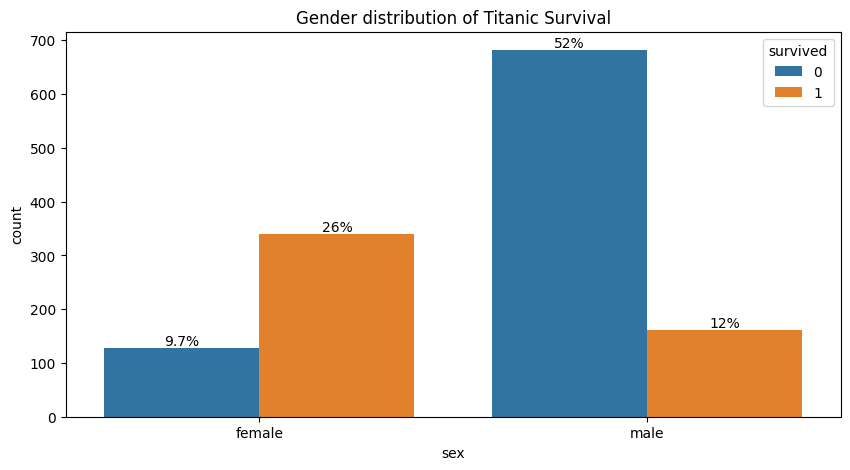

In [41]:
plt.figure(figsize=(10, 5))
g = sns.countplot(x="sex", hue="survived", data=data)
for p in g.patches:
  x = p.get_bbox().get_points()[:,0]
  y = p.get_bbox().get_points()[1,1]
  g.annotate('{:.2g}%'.format(100.*y/len(data)), (x.mean(), y), ha='center', va='bottom')
plt.title("Gender distribution of Titanic Survival");

H0: male survival = female survival

H1: male survival != female survival

using 5% alpha level, confidene level = 95%

In [64]:
female_survived = sex_survival['female'][1]
male_survived = sex_survival['male'][1]
male_pop = data[data['sex'] == 'male']['sex'].count()
female_pop = data[data['sex'] == 'female']['sex'].count()

In [66]:
hypothesis_statistics(female_survived, male_survived, female_pop, male_pop, 0.05)

'19.12817157522173 Test falls within rejection region, reject H0'

## Does class impact survival on the titanic?
- 62% of first class passengers survived. This can be linked to the fact that first class passengers boarded the titanic first and were given priority 
- As established earlier that female have a 73% survival rate. The class of females on the ship also impacts survival.
- 96% of the females in first class survived, while there is a 49% chance of survival in third class. 
- Two proportion Z test confirms that the survival rate of women in first class and other class are not equal at 95% confidence
- Class also affects men, as 34% of male in first class survived
- Class and sex thus impact survival on titanic

In [74]:
pd.crosstab(data.survived, data.pclass, normalize='columns' )

pclass,1,2,3
survived,,,
0,0.380805,0.570397,0.744711
1,0.619195,0.429603,0.255289


In [81]:
survival_class_age = pd.crosstab(data.survived, [data.sex, data.pclass] )
survival_class_age

sex      female          male          
pclass        1   2    3    1    2    3
survived                               
0             5  12  110  118  146  418
1           139  94  106   61   25   75

In [70]:
pd.crosstab(data.survived, [data.sex, data.pclass], normalize='columns', margins=True )

sex         female                          male                          All
pclass           1         2         3         1         2        3          
survived                                                                     
0         0.034722  0.113208  0.509259  0.659218  0.853801  0.84787  0.618029
1         0.965278  0.886792  0.490741  0.340782  0.146199  0.15213  0.381971

c:\Users\Oyindolapo Komolafe\OneDrive\Old\Documents\PythonProjects\mba6636\regression\env\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\Users\Oyindolapo Komolafe\OneDrive\Old\Documents\PythonProjects\mba6636\regression\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Comparing titanic survival rate by class and sex')

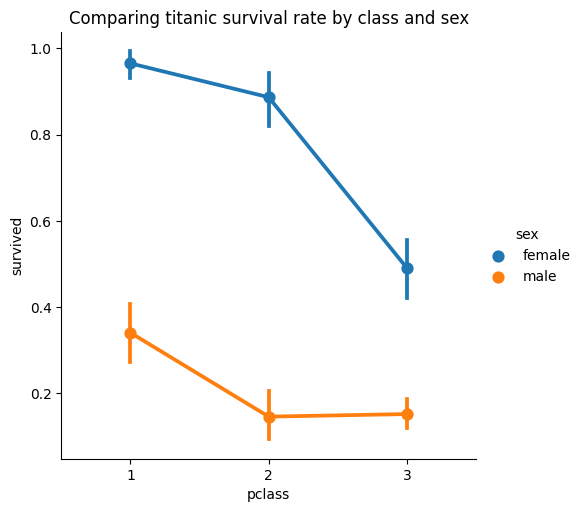

In [79]:
sns.factorplot('pclass', 'survived', hue='sex', data=data)
plt.title('Comparing titanic survival rate by class and sex');

H0: female in first class survival = female not in first class survival

H1: female in first class survival != female in first class survival

using 5% alpha level, confidene level = 95%

In [90]:
female_first_survived = survival_class_age['female'][1][1]
female_not_first_survived = survival_class_age['female'][2][1] + survival_class_age['female'][3][1]
female_first_pop = survival_class_age['female'][1].sum()
female_not_first_pop = survival_class_age['female'][2].sum() + survival_class_age['female'][3].sum()

In [91]:
hypothesis_statistics(female_first_survived, female_not_first_survived, female_first_pop, female_not_first_pop, 0.05)

'7.710109173417564 Test falls within rejection region, reject H0'

## Does age affect survival?
- There are 262 missing age in the dataset
- The youngest was 2 months old, oldest was 80 and average age was 30 years
- Children were proritized but class played a factor
- Middle age adults recorded the maximum number of deaths
- Old Adults has the least chance of surviving

In [80]:
data.age.describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: age, dtype: float64

since age is grouped, we can attempt to deduce the age bracket from name.

In [164]:
def bracket_age(x, name):
    if  x <= 0 or pd.isna(x):
        if 'Mr' in name:
            return 'Middle age adults'
        elif 'Dr' in name:
            return 'Middle age adults'
        elif 'Mrs' in name:
            return 'Middle age adults'
        elif 'Miss' in name:
            return 'Young adults'
        elif 'Master' in name:
            return '0 to 12'
        elif 'Ms' in name:
            return 'Young adults'
    elif x > 0 and x <= 12:
        return '0 to 12'
    elif x > 12 and x <= 18:
        return '12 to 18'
    elif x > 18 and x <= 30:
        return 'Young adults' 
    elif x > 30 and x <= 60:
        return 'Middle age adults'
    else:
        return 'Old Adults' 

data['age_bracket'] = data.apply(lambda x: bracket_age(x['age'],x['name']), axis = 1)
train['age_bracket'] = train.apply(lambda x: bracket_age(x['Age'],x['Name']), axis = 1)
test['age_bracket'] = test.apply(lambda x: bracket_age(x['Age'],x['Name']), axis = 1)

In [168]:
pd.crosstab([data['age_bracket'], data.pclass], data.survived )

survived                    0    1
age_bracket       pclass          
0 to 12           1         1    4
                  2         0   24
                  3        44   29
12 to 18          1         2   14
                  2        11    7
                  3        45   20
Middle age adults 1        84  128
                  2        75   38
                  3       238   46
Old Adults        1        15    6
                  2         5    1
                  3         5    1
Young adults      1        21   48
                  2        67   49
                  3       196   85

In [167]:
pd.crosstab( data.survived,[data['age_bracket'], data.pclass], normalize='columns' )

age_bracket 0 to 12               12 to 18                      \
pclass            1    2        3        1         2         3   
survived                                                         
0               0.2  0.0  0.60274    0.125  0.611111  0.692308   
1               0.8  1.0  0.39726    0.875  0.388889  0.307692   

age_bracket Middle age adults                     Old Adults            \
pclass                      1         2         3          1         2   
survived                                                                 
0                    0.396226  0.663717  0.838028   0.714286  0.833333   
1                    0.603774  0.336283  0.161972   0.285714  0.166667   

age_bracket           Young adults                      
pclass              3            1         2         3  
survived                                                
0            0.833333     0.304348  0.577586  0.697509  
1            0.166667     0.695652  0.422414  0.302491

c:\Users\Oyindolapo Komolafe\OneDrive\Old\Documents\PythonProjects\mba6636\regression\env\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\Users\Oyindolapo Komolafe\OneDrive\Old\Documents\PythonProjects\mba6636\regression\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


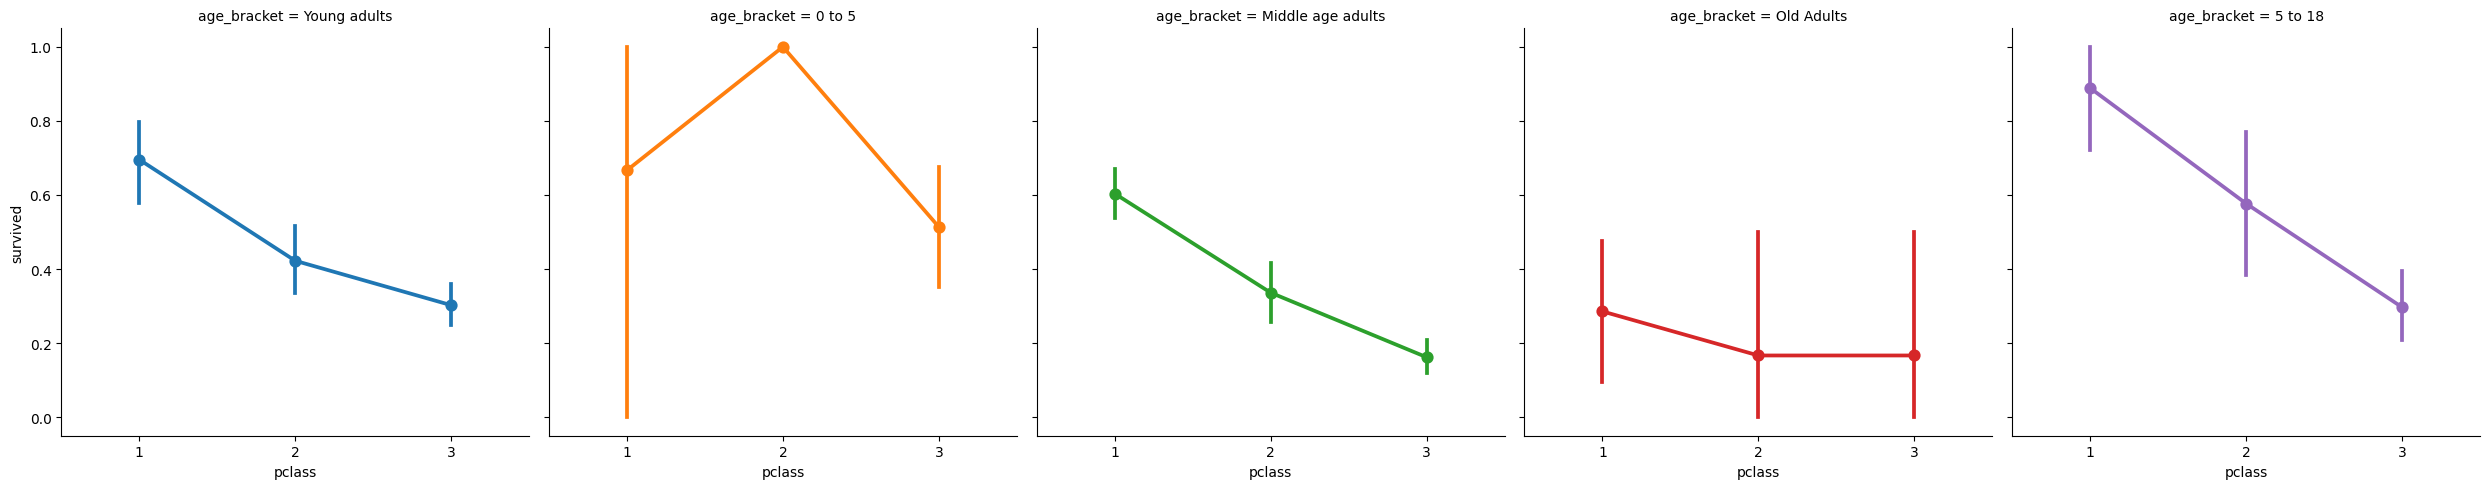

In [161]:
sns.factorplot('pclass', 'survived', hue='age_bracket', col='age_bracket', data=data);

## Did siblings/family die/survive together?


In [174]:
pd.crosstab( data.survived,data.sibsp, normalize='columns' )

sibsp,0,1,2,3,4,5,8
survived,,,,,,,
0,0.653199,0.489028,0.547619,0.7,0.863636,1.0,1.0
1,0.346801,0.510972,0.452381,0.3,0.136364,0.0,0.0


In [169]:
pd.crosstab([data.sibsp, data.pclass], data.survived )

survived        0    1
sibsp pclass          
0     1        87  111
      2       113   69
      3       382  129
1     1        34   79
      2        39   43
      3        83   41
2     1         1    7
      2         6    6
      3        16    6
3     1         1    3
      2         0    1
      3        13    2
4     3        19    3
5     3         6    0
8     3         9    0

In [21]:
data.parch.value_counts()

0    1002
1     170
2     113
3       8
4       6
5       6
6       2
9       2
Name: parch, dtype: int64